In [15]:
library(foreach)
library(doParallel)
#library(tidyverse)
library(data.table)
library(gridExtra)
#library(ggridges)
library("IBMPopSim")
library("ggplot2")
library("Rcpp")
library(dplyr)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [13]:
install.packages("data.table")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
# Generate initial population
# N number of individuals in the initial population
# N_invad number of individuals invading
def_pop_init<-function(N=100,N_invad=1){
    pop_init <- data.frame(
        "birth" = rep(0,N), 
        "death" = as.double(NA),
        "Lansing" = rep(FALSE,N),
        "xb"= 1.5, 
        "xd" =  0.83, 
        "lignee"=1:N)
    pop_invader <- data.frame(
        "birth" = rep(0,N_invad), 
        "death" = as.double(NA),
        "Lansing" = rep(TRUE,N_invad),
        "xb"= 1.5, 
        "xd" =  1.3, 
        "lignee"= (N+1):(N+N_invad))
    pop_init <- rbind(pop_init, pop_invader)
    return(pop_init)
}
pop_init<-def_pop_init()
get_characteristics(pop_init)
head(pop_init)
tail(pop_init)

Lansing       xb       xd   lignee 
  "bool" "double" "double"    "int"

,birth,death,Lansing,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>
1,0,NA,FALSE,1.5,0.83,1
2,0,NA,FALSE,1.5,0.83,2
3,0,NA,FALSE,1.5,0.83,3
4,0,NA,FALSE,1.5,0.83,4
5,0,NA,FALSE,1.5,0.83,5
6,0,NA,FALSE,1.5,0.83,6


,birth,death,Lansing,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>
96,0,NA,FALSE,1.5,0.83,96
97,0,NA,FALSE,1.5,0.83,97
98,0,NA,FALSE,1.5,0.83,98
99,0,NA,FALSE,1.5,0.83,99
100,0,NA,FALSE,1.5,0.83,100
101,0,NA,TRUE,1.5,1.30,101


In [6]:
params_birth <- list("ib"= 1, "p"=0.1 , "var_mut"=0.05)

birth_event <- mk_event_individual( type = "birth",
  intensity_code = ' if (age(I,t) < I.xb)
                        result = ib; 
                    else 
                        result =0;',  # each individual  I can give birth at rate ib if its age is less than xb
  kernel_code = 'if (CUnif() < p)
                     newI.xb = max(0., CNorm(I.xb, var_mut)); 
                 else
                     newI.xb = I.xb;
                if (I.Lansing & (age(I,t)> I.xd) & (age(I,t)<I.xb))
                     newI.xd =0;
                 else{
                    if (CUnif()<p)
                        newI.xd =max(0., CNorm(I.xd, var_mut));
                     else 
                        newI.xd =I.xd;}
                 newI.Lansing =I.Lansing;
                 newI.lignee =I.lignee;') 

## Death event 
### parameters
params_death <- list("intens"=1, "compet"= 0.0009)

## Deaths due to interactions
death_event1 <- mk_event_interaction(name='death1',
  type = "death",
  interaction_code = "result = compet;" 
)

## Deaths due to aging 
death_event2 <- mk_event_individual(name='death2', type="death",
                  intensity_code = ' if (age(I,t)>I.xd) result= intens; 
                                     else result =0;')

In [7]:
# Model creation 
model <- mk_model(
  characteristics = get_characteristics(pop_init),
  events = list(birth_event, death_event1, death_event2),
  parameters = c(params_birth, params_death)
)
summary(model)

Events:
#1: individual event of type birth
#2: interaction event of type death
#3: individual event of type death
--------------------------------------- 
Individual description:
names:  birth death Lansing xb xd lignee 
R types:  double double logical double double integer 
C types:  double double bool double double int
--------------------------------------- 
R parameters available in C++ code:
names:  ib p var_mut intens compet 
R types:  double double double double double 
C types:  double double double double double

In [8]:
## Bounds for birth and death rates 
birth_intensity_max <- params_birth$ib
interaction_fun_max <- params_death$compet
death2_max <- params_death$intens

In [9]:
T = 1500 # Simulation end time 

In [16]:
pop_out_multi <- matrix(,ncol=7)
colnames(pop_out_multi) <- c("birth","death","Lansing","xb","xd","lignee", "n_pop")
pop_out_multi <- as.data.table(pop_out_multi)
n_pop=0
n_sims=10

In [17]:
for (i in 1:n_sims){
  sim_out <- popsim(model = model,
                    population = pop_init,
                    events_bounds = c('birth'=birth_intensity_max, 'death1'=interaction_fun_max,'death2'= death2_max),
                    parameters = c(params_birth, params_death),
                    time = T)
  
  pop_out_multi <- rbind(pop_out_multi ,sim_out$population %>% mutate(n_pop))
  n_pop=n_pop+1
}
pop_out_multi<-pop_out_multi[-1,]

Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] Simulation on  [0, 1500] 

In [18]:
head(pop_out_multi)
tail(pop_out_multi)
length(pop_out_multi$birth)

birth,death,Lansing,xb,xd,lignee,n_pop
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
1495.563,NA,FALSE,3.700154,2.966325,91,0
1495.699,NA,FALSE,4.162336,3.259111,91,0
1495.881,NA,FALSE,3.916909,3.011817,91,0
1495.923,NA,FALSE,4.126060,3.332508,91,0
1496.027,NA,FALSE,4.030885,3.555516,91,0
1496.031,NA,FALSE,3.821430,3.380159,91,0


birth,death,Lansing,xb,xd,lignee,n_pop
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
1499.822,1499.988,FALSE,4.465877,3.650498,12,9
1499.837,1499.989,FALSE,4.272457,4.145637,12,9
1499.843,1499.969,FALSE,4.499977,4.016764,12,9
1499.874,1499.998,FALSE,4.302485,4.008424,12,9
1499.889,1499.988,FALSE,4.161406,3.474658,12,9
1499.934,1499.985,FALSE,4.624371,3.650498,12,9


[1] 14477721

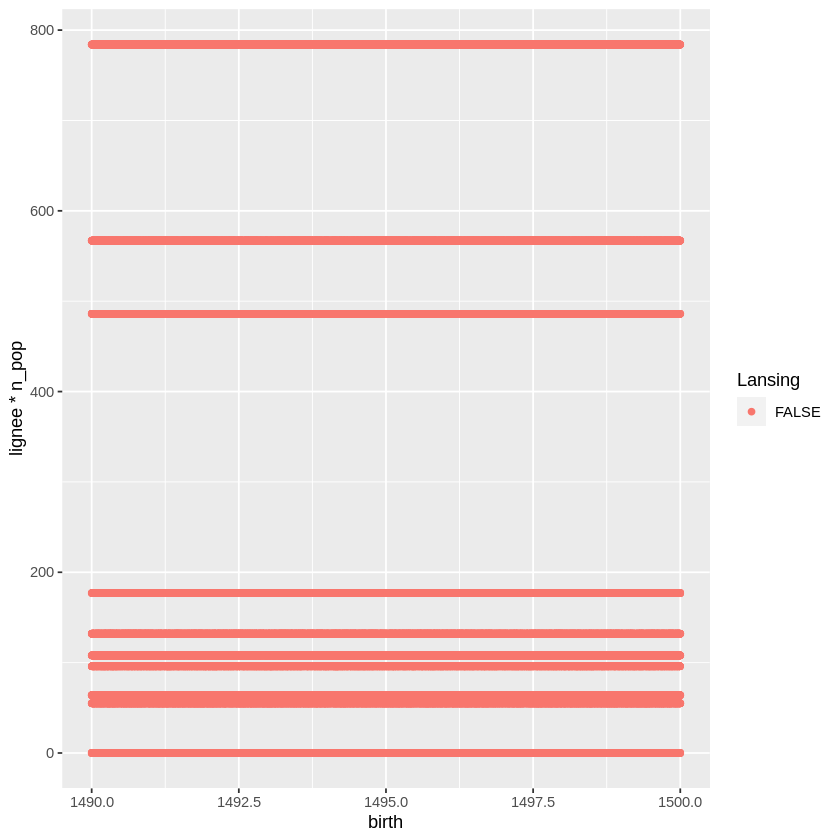

In [19]:
ggplot(pop_out_multi %>% filter(birth>1490), aes(x=birth, y=lignee*n_pop, color=Lansing))+
    geom_point()

In [20]:
test_Lansing <- pop_out_multi %>% filter(Lansing) %>% mutate(xb-xd); test_Lansing <- density(test_Lansing$`xb - xd`)$x[which.max(density(test_Lansing$`xb - xd`)$y)]
test_nonLansing <- pop_out_multi %>% filter(!Lansing) %>% mutate(xb-xd); test_nonLansing <- density(test_nonLansing$`xb - xd`)$x[which.max(density(test_nonLansing$`xb - xd`)$y)]

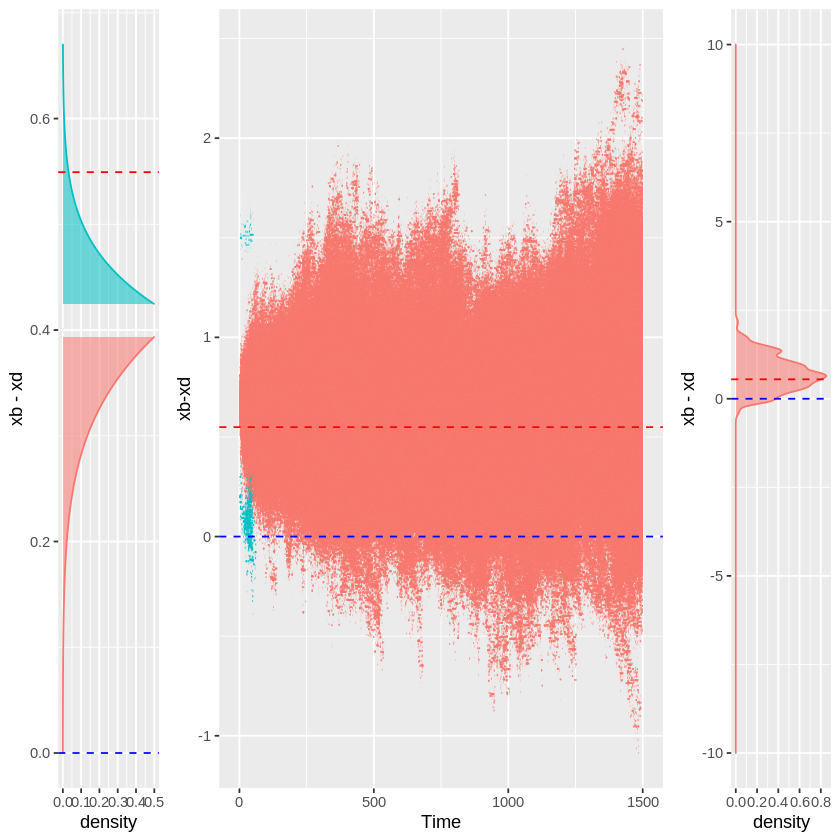

In [21]:
t0density <-  ggplot(pop_out_multi %>% filter(birth==0), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.5)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                ylim(0,0.5) + 
                coord_flip() +
                theme(legend.position="none")

soldensity <- ggplot(pop_out_multi %>% filter(birth>1499), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.5)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                coord_flip() +
                xlim(-10,10) +
                theme(legend.position="none")

xbxd_evol <- ggplot(pop_out_multi , aes(color=as.logical(Lansing))) + 
                geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.01) , na.rm=TRUE)+
                xlab("Time") +
                ylab("xb-xd") + 
                geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
                geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
                theme(legend.position="none")

p = grid.arrange(t0density, xbxd_evol, soldensity, ncol=3, nrow = 1, widths=c(2,6,2))

In [22]:
ggplot(pop_out_mini_per_Lansing2, aes(y=Lansing_xd))+
  geom_density_ridges2(aes(x=xb-xd, fill=paste(Lansing_xd, Lansing), alpha = 0.9), scale = 0.9)+  
  geom_vline(xintercept=log(3)/2, color = "red", linetype = "dashed") +
  geom_vline(xintercept = 0, color = "blue", linetype = "dashed") +
  labs(y = "(1 - Lansing effect magnitude)", x = "xb - xd") + 
  scale_fill_cyclical(values = c("#f26d68", "#15d8ed"), labels = c("Lansing", "non-Lansing"))+
  xlim(-5,5) + coord_flip() 

#plot lines

ERROR: Error in ggplot(pop_out_mini_per_Lansing2, aes(y = Lansing_xd)): object 'pop_out_mini_per_Lansing2' not found
